In [1]:
!pip --quiet install gdown pycocotools

In [5]:
import numpy as np
import torch
import cv2 
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
import gdown
import random
from IPython.display import display
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import warnings
import gc
warnings.filterwarnings('ignore')

### TACO 
the TACO dataset paper used Mask R-CNN architechture --> Pixel-wise segmentation (through classification)

In [ ]:
df_sample['img_file']

In [ ]:
sample_dir = r"/kaggle/input/tacotrashdataset/data"
rn = random.randint(0, len(os.listdir(sample_dir)))
# rn = 6
print('image-ID: ', rn)

df_all_sample = pd.read_csv(r"/kaggle/input/tacotrashdataset/meta_df.csv")
display(df_all_sample.head(3))

df_sample = df_all_sample[df_all_sample['img_id'] == rn]
display(df_sample)

img_path = os.path.join(sample_dir, df_sample['img_file'].tolist()[0])
sample_img = cv2.imread(img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2BGR)
annot_img = sample_img.copy()
x, y, w, h = int(df_sample['x'].tolist()[0]), int(df_sample['y'].tolist()[0]), int(df_sample['width'].tolist()[0]), int(df_sample['height'].tolist()[0])
print(x, y, w, h)
cv2.rectangle(annot_img, (x, y), (x + w, y + h), (0, 255, 0), 5)

annot_img = cv2.resize(annot_img, (512, 512))
sample_img = cv2.resize(sample_img, (512, 512))

print(sample_img.shape)

fig, axs = plt.subplots(1, 2 ,figsize = (7, 7))

axs[0].imshow(sample_img)
axs[0].set_title('TACO')

axs[1].imshow(annot_img)
axs[1].set_title('BBox')

plt.show()

In [ ]:
from pycocotools import mask as maskUtils
import json

image_id = random.randint(0, len(annot_json['images']))
# image_id = 7

df_sample = df_all_sample[df_all_sample['img_id'] == image_id]
display(df_sample)

img_path = os.path.join(sample_dir, df_sample['img_file'].tolist()[0])
sample_img = cv2.imread(img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2BGR)
sample_img = cv2.resize(sample_img, (512, 512))

plt.imshow(sample_img)
plt.title("Image_ID: " + str(image_id))
plt.show()

with open('/kaggle/input/tacotrashdataset/data/annotations.json', 'rb') as f:
    annot = f.read()
f.close()

print('No. of images: ', len(annot_json['images']))
print()

img_width, img_height =  df_all_sample[df_all_sample['img_id'] == image_id]['img_width'].tolist()[0], df_all_sample[df_all_sample['img_id'] == image_id]['img_height'].tolist()[0]
print('image_id: ', image_id, ', image_w: ', img_width, ', image_h: ', img_height)
print()
print(annot_json.keys())
print()
annot_json = json.loads(annot)
selected_annot = [d for d in annot_json['annotations'] if d['image_id'] == image_id]

print(selected_annot)
print()


def seg_visx(sample_img, annot_list, image_id, height, width, alpha = 0.55, beta = 0.45):
     
    mask_list = []
    
    for i, annot in enumerate(annot_list):
        
        segm = annot['segmentation']
        print('Image_ID: ', annot['image_id'])
        
        if isinstance(segm, list):
            
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)        
        elif isinstance(segm['counts'], list):
            
            rle = maskUtils.frPyObjects(segm, height, width)      
        else:
            
            rle = annot['segmentation']
            
        mask = maskUtils.decode(rle)
        mask = cv2.resize(mask, (512, 512))
#         color_mask = np.zeros_like(sample_img)
    
        if i == 0:      
            color_mask = np.zeros_like(sample_img)
            bin_mask = mask
            
        else:
            bin_mask[mask == 1] = 1
            
        color_mask[bin_mask == 1] = (0, 255, 0)  # Green color with alpha=100 (adjust as needed)
        mask_list.append(mask)
        
    color_mask_img = cv2.addWeighted(sample_img, alpha, color_mask, beta, 0)  # Blend with mask1
    
    return mask_list, bin_mask, color_mask_img

# height, width = 512, 512
_, bin_mask, color_mask_img = seg_visx(sample_img, selected_annot, image_id, img_height, img_width)

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(bin_mask, cmap = 'gray')
axs[0].set_title('Seg-Mask')

axs[1].imshow(color_mask_img)
axs[1].set_title('Masked-Img')

plt.show()

### India-Specific | IndoSet
We aim to perform Binary Instance pixel-wise classification into Liftables (plastic Bag, Paper etc) and Removables (Gutka Stains, Pan Masala etc.) 

https://drive.google.com/file/d/1e3cwXtLE8FpCCO_svfSV6YgLeqS6jTUV/view?usp=drive_link

In [ ]:
india_data_path = r"/kaggle/input/data-india-v1/data.txt"
with open(india_data_path, 'r') as f:
    file_id = f.read()[3:].split('/')[-2]
    
print('File-ID: ', file_id)

ft = time.time()

ouput_path = "/kaggle/working/india-data.zip"

file_link = r"https://drive.google.com/uc?id=" + file_id
gdown.download(file_link, quiet=False, output = ouput_path)
!unzip -q "/kaggle/working/india-data.zip"

lt = time.time()
print('time-taken: ', (lt - ft) / 60, ' mins')

In [ ]:
india_data_path = r"/kaggle/working/Dgen-VES"
rn = random.randint(0, len(os.listdir(india_data_path)))

sample_img_path = os.path.join(india_data_path, os.listdir(india_data_path)[rn])
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2BGR)
sample_img = cv2.resize(sample_img, (512, 512))
print(sample_img.shape)

fig = plt.figure(figsize = (5, 5))
plt.imshow(sample_img)
plt.title('IndoSet')

plt.show()

----

### Segementation Module

---

In [ ]:
import importlib
importlib.reload(dmp)

time-taken for data-loading:  0.2910307327906291 mins
Samples-Size:  (100, 512, 512, 3) Mask-Size:  (100, 512, 512)



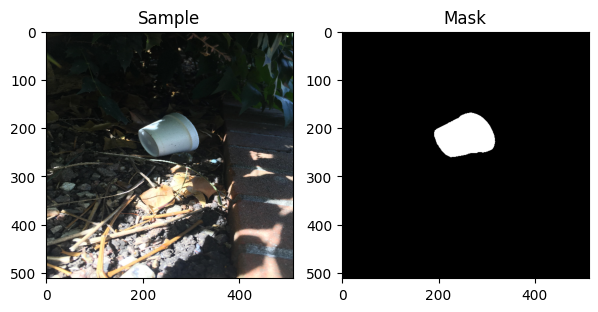

In [6]:
import data_mask_pipeline as dmp

num_samples = 100

ft = time.time()
dsp = dmp.data_segment_pipeline(num_samples = num_samples)
samples, masks = dsp.seg_visx()
lt = time.time()

print('time-taken for data-loading: ', (lt - ft) / 60, 'mins')
print('Samples-Size: ', samples.shape, 'Mask-Size: ', masks.shape)
print()

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

rn = random.randint(0, num_samples)

axs[0].imshow(samples[rn])
axs[0].set_title('Sample')

axs[1].imshow(masks[rn], cmap = 'gray')
axs[1].set_title('Mask')

plt.show()

Hugginface-Instance Prediction

In [ ]:
!pip -q install -U transformers accelerate

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import sys

# load Mask2Former fine-tuned on COCO panoptic segmentation

# processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-instance")
# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-instance")

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")


# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.fromarray(samples[rn])

# print(type(image), image.size)
# plt.imshow(image)
# plt.show()

# sys.exit()

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
predicted_panoptic_map = result["segmentation"]

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(image)
axs[0].set_title('Image')

axs[1].imshow(predicted_panoptic_map)
axs[1].set_title('Panoptic Map')

plt.show()

#### Data-Augmentation

time-taken for data-augmentation:  0.1639311671257019  mins
(500, 512, 512, 3) (600, 512, 512, 3) (500, 512, 512) (600, 512, 512)


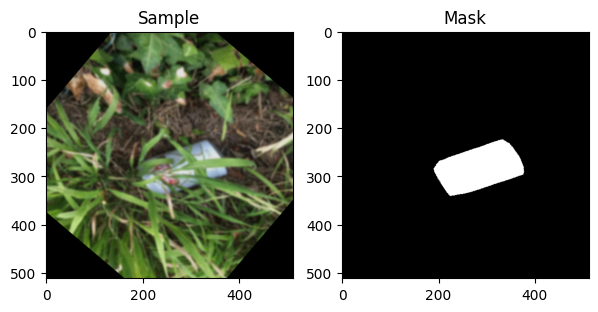

5926

In [7]:
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["Blur", "AWGN", "Add","Multiply"]:
        return False
    else:
        return default

def data_aug_pipeline(samples, masks, n_aug = 5):
    
    samples_aug, masks_aug = [], []
    
    for sample_image, sample_mask in zip(samples, masks):
    
        seq = iaa.Sequential([
            iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="AWGN"),
            iaa.GaussianBlur(sigma=(0.0, 3.0), name="Blur"),
            iaa.Fliplr(0.5),
            iaa.Add((-20, 20),name="Add"),
            iaa.Multiply((0.8, 1.2), name="Multiply"),
            iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees
        ], random_order=True)

        hooks_masks = ia.HooksImages(activator=activator_masks)

        for i in range(n_aug):

            seq_det = seq.to_deterministic()
            image_augmented = seq_det.augment_image(sample_image)
            mask_augmented = seq_det.augment_image(sample_mask.astype(np.uint8), hooks=hooks_masks)

            samples_aug.append(image_augmented)
            masks_aug.append(mask_augmented)
    
    return np.array(samples_aug), np.array(masks_aug)

ft = time.time()
aug_samples, aug_masks = data_aug_pipeline(samples, masks)
lt = time.time()

print('time-taken for data-augmentation: ', (lt - ft)/60, ' mins')

samples_all = np.concatenate((samples, aug_samples))
masks_all = np.concatenate((masks, aug_masks))

shuffle_order = np.random.permutation(len(samples_all))

samples_all, masks_all = samples_all[shuffle_order], masks_all[shuffle_order]

print(aug_samples.shape, samples_all.shape, aug_masks.shape, masks_all.shape)

fig, axs = plt.subplots(1, 2, figsize = (7, 7))

rn = random.randint(0, num_samples)

axs[0].imshow(samples_all[rn])
axs[0].set_title('Sample')

axs[1].imshow(masks_all[rn], cmap = 'gray')
axs[1].set_title('Mask')

plt.show()

del samples
del masks
del aug_samples
del aug_masks

gc.collect()

### Masked-Segmentation | UNET
BBox Anchoring is needed

In [77]:
import torch
import torch.nn as nn
from torchsummary import summary

class SegmentationModel(nn.Module):
    def __init__(self, img_size, num_classes):
        super().__init__()

        self.entry_block = nn.Sequential(
            nn.Linear(in_features = img_size[1], out_features = img_size[1]),
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        ## More Convolution + Lower-Space Proj. | Custom Module Addition
        self.downsample_blocks = nn.ModuleList([
            EncoderBlock(32, 64),
            EncoderBlock(64, 128),
            EncoderBlock(128, 256),
            EncoderBlock(256, 512)
        ])
        
        self.upsample_blocks = nn.ModuleList([
            DecoderBlock(512, 256),
            DecoderBlock(256, 128),
            DecoderBlock(128, 64),
            DecoderBlock(64, 32)
        ])
        
        self.final_conv = nn.Conv2d(in_channels = 32, out_channels = num_classes, kernel_size = 3, padding = 1)
        self.final_trans_conv = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):
        
        x = self.entry_block(x)
        residuals = []
        for block in self.downsample_blocks:
            x, residual = block(x)
            residuals.append(residual)
            
        for block, residual in zip(self.upsample_blocks, reversed(residuals)):
            x = block(x, residual)
        x = self.final_trans_conv(x)
        x = self.final_conv(x)
        return x
    
class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
        )
        self.residual_conv = nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 1, stride = 2)
    
    def forward(self, x):
        residual = self.residual_conv(x)
        x = self.block(x)
        x = x + residual
        return x, residual
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace = True),
        )
        self.residual_conv = nn.ConvTranspose2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 1)
    
    def forward(self, x, residual):
        residual = nn.functional.interpolate(residual, scale_factor = 2, mode = 'nearest')
        residual = self.residual_conv(residual)
        x = self.block(x)
        x = x + residual
        return x
    
img_size = (3, 512, 512)
num_classes = 2
model = SegmentationModel(img_size, num_classes)

# print(model)
summary(model, input_size = img_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 3, 512, 512]         262,656
            Conv2d-2         [-1, 32, 256, 256]             896
       BatchNorm2d-3         [-1, 32, 256, 256]              64
              ReLU-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           2,112
            Conv2d-6         [-1, 64, 256, 256]          18,496
       BatchNorm2d-7         [-1, 64, 256, 256]             128
              ReLU-8         [-1, 64, 256, 256]               0
         MaxPool2d-9         [-1, 64, 128, 128]               0
     EncoderBlock-10  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
           Conv2d-11          [-1, 128, 64, 64]           8,320
           Conv2d-12        [-1, 128, 128, 128]          73,856
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14    

In [17]:
!pip -q install -U torchvision

In [89]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class SegDataset(Dataset):
    def __init__(self, samples, masks):
        self.samples = samples
        self.masks = masks
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        mask = self.masks[idx]
        sample = self.transform(sample).float() 
        
        mask = torch.from_numpy(mask)
        
#         sample = (sample / 255).permute(2, 0, 1).float()
        mask = torch.nn.functional.one_hot(mask.long(), num_classes=num_classes)
#         mask = mask.permute(2, 0, 1).float()
        
        return sample, mask

train_num, test_num = 0.85, 0.15 
train_samples, train_masks = samples_all[:int(train_num * len(samples_all))], masks_all[:int(train_num * len(samples_all))]   
test_samples, test_masks = samples_all[int(train_num * len(samples_all)) + 1:], masks_all[int(train_num * len(samples_all)) + 1:]

train_dataset = SegDataset(train_samples, train_masks)
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)

In [33]:
# for sample, mask in train_dataloader:
#     print(sample[0][:5])
#     break

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epoch = 15

for epoch in range(num_epoch):
    
    for samples, masks in train_dataloader:
        
        optimizer.zero_grad()        
#         print(samples.dtype, masks.dtype, samples.shape, masks.shape)
        outputs = model(samples)
        outputs = outputs.permute(0, 2, 3, 1)
#         print(type(outputs), outputs.size(), outputs.dtype, type(masks), masks.size(), masks.dtype)
        loss = criterion(outputs, masks.float())
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch - {epoch}/{num_epoch} - Loss: {loss.item():.4f}')

In [ ]:
t